### Approaches to catch "ordinary" and "unusual" days

The distribution of the "ordinary" and "unusual" is as follows. The number of steps for the current day is compared with an interval of two standard deviations from the average number of steps in the last few days. It seems to me that this allows us to take into account the change in the number of steps taken per day over time. The more often the user goes through an approximately equal number of steps per day, the sooner this number becomes normal. There are two assumptions here that allow us to make exceptions to the main approach.

**Memory** <br>
It is unlikely that the average user remembers how much or she went on Wednesday two weeks ago. Activity for the last 5 days, as it seems to me, is better described by the user. Therefore, when I define a “normal” day or “unusual” I take the last 5 days before it and compare the activity on the current day and five days before it.

**Habit** <br>
It is difficult to say for what specific time a habit is developed, therefore, we will assume that if repeated patterns of movement within a week are observed within one month, then such data is considered habitual, even if they differ from other days of the week. For example, a person walks 20,000 steps every Thursday in one month, with an average of 10,000 steps on other days of the week. In this case, Thursday is considered a normal day, despite the fact that the number of steps differs by half from the average number on other days of the week. In addition, if next month on Thursday a person walks 10,000 steps, then such a day is considered unusual, since it is very different from the habit of walking on Thursday 20,000 steps.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.io as pio
pio.renderers.default = "svg"

### Preparing data

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/ipushin/welltory/master/Fitness%20Tracker%20Data.csv')
data.shape

(39671, 7)

In [35]:
data.head()

,Time End,Time End Local Tz,Time Offset,Time Start,Time Start Local Tz,User ID,Value
0,2019-05-05T09:40:00+03:00,2019-05-05T12:40:00+03:00,10800,2019-05-05T09:39:59+03:00,2019-05-05T12:39:59+03:00,2166,1.0
1,2019-05-05T11:13:29+03:00,2019-05-05T14:13:29+03:00,10800,2019-05-05T11:12:51+03:00,2019-05-05T14:12:51+03:00,2166,34.0
2,2019-05-05T12:07:42+03:00,2019-05-05T15:07:42+03:00,10800,2019-05-05T12:07:39+03:00,2019-05-05T15:07:39+03:00,2166,1.0
3,2019-05-05T13:04:05+03:00,2019-05-05T16:04:05+03:00,10800,2019-05-05T13:04:02+03:00,2019-05-05T16:04:02+03:00,2166,3.0
4,2019-05-05T13:18:18+03:00,2019-05-05T16:18:18+03:00,10800,2019-05-05T13:18:13+03:00,2019-05-05T16:18:13+03:00,2166,6.0


In [36]:
# number of steps per day
data['date'] = data['Time Start'].str.split(pat='T',expand=True)[0]
steps = pd.DataFrame(data.groupby('date')['Value'].sum()).reset_index()
steps['date'] = pd.to_datetime(steps['date'])
steps = steps.rename(columns={'Value': 'steps'})

In [37]:
# day of the week
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
steps['day'] = steps['date'].apply(lambda x: x.weekday())
for i,j in enumerate(days):
    steps['day'] = steps['day'].replace({i:j})
steps.shape

(105, 3)

In [38]:
steps.head()

,date,steps,day
0,2019-05-01,21.0,Wednesday
1,2019-05-02,12956.0,Thursday
2,2019-05-03,17003.0,Friday
3,2019-05-04,14312.0,Saturday
4,2019-05-05,11124.0,Sunday


### Graphs

<b> Number of steps per day

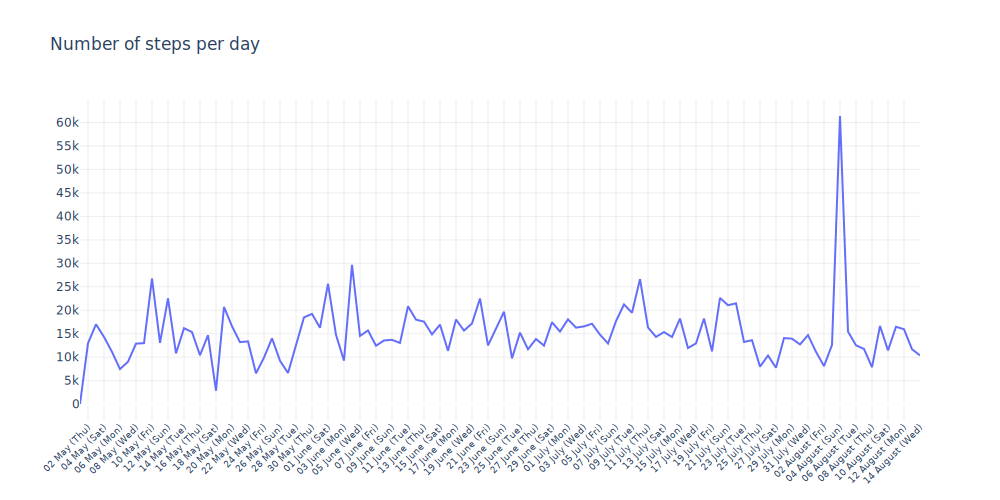

In [41]:
fig = go.Figure([go.Scatter(x=steps['date'], y=steps['steps'])])
fig.update_layout(title_text='Number of steps per day',
                  width=1000, height=500, plot_bgcolor='rgba(0,0,0,0)', showlegend=False,
                  yaxis=dict(gridcolor='#EEEEEE', nticks=15),
                  xaxis=dict(tickangle=-45, gridcolor='#EEEEEE', 
                             tickformat = '%d %B (%a)', nticks=70, tickfont=dict(size=9)))
pio.show(fig, width=1000, height=500)

<b> Decomposing time data

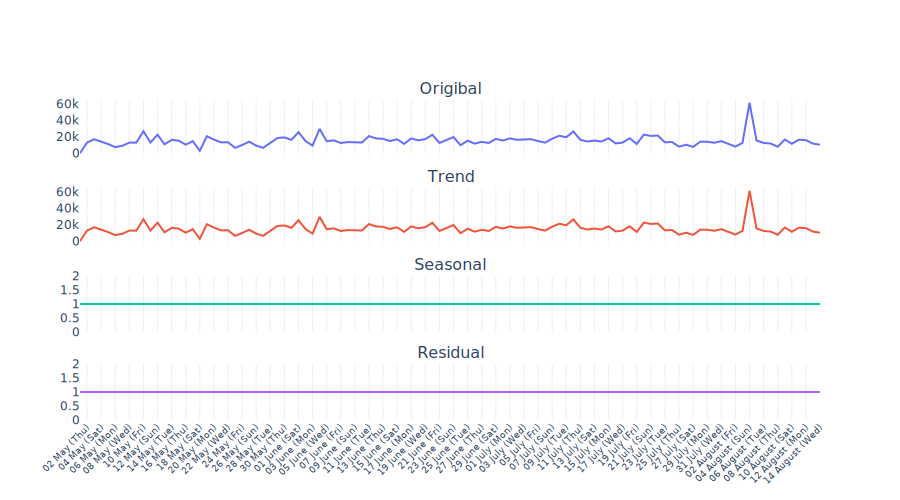

In [42]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(steps['steps'], model='multiplicative',freq=1)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig = make_subplots(rows=4, cols=1, vertical_spacing = 0.1, shared_xaxes=True,
                    subplot_titles=('Original', 'Trend', 'Seasonal', 'Residual'))
fig.add_trace(go.Scatter(x=steps['date'], y=steps['steps']), row=1, col=1)
fig.add_trace(go.Scatter(x=steps['date'], y=trend.values), row=2, col=1)
fig.add_trace(go.Scatter(x=steps['date'], y=seasonal.values), row=3, col=1)
fig.add_trace(go.Scatter(x=steps['date'], y=residual.values), row=4, col=1)

fig.update_layout(width=900, height=500, plot_bgcolor='rgba(0,0,0,0)', showlegend=False)
fig.update_xaxes(tickangle=-45, gridcolor='#EEEEEE', tickformat = '%d %B (%a)', nticks=105, tickfont=dict(size=9), row=4, col=1)
fig.update_xaxes(gridcolor='#EEEEEE',  nticks=105, row=3, col=1)
fig.update_xaxes(gridcolor='#EEEEEE',  nticks=105, row=2, col=1)
fig.update_xaxes(gridcolor='#EEEEEE',  nticks=105, row=1, col=1)
pio.show(fig, width=900, height=500)

+ <i>  There is no clear trend and seasonality, which means that the entire time interval for evaluating a “normal / unusual” day can be considered equivalent

<b> Number of steps distribution

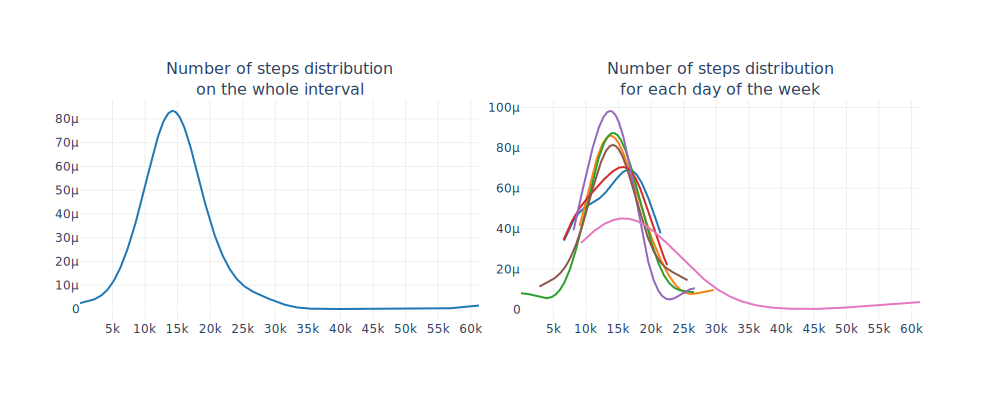

In [43]:
import plotly.figure_factory as ff
fig = make_subplots(rows=1, cols=2, horizontal_spacing = 0.05, 
                    subplot_titles=('Number of steps distribution <br> on the whole interval', 'Number of steps distribution <br> for each day of the week')
                   )
fig_dist = ff.create_distplot([steps['steps']], ['Number of steps distribution'], show_hist=False, show_curve=True, show_rug=False)
fig.append_trace(fig_dist['data'][0], row=1, col=1)

plot_data = []
for i in days:
    day_data = steps[steps['day'] == i]["steps"].values
    plot_data.extend([day_data])

fig_dist_week = ff.create_distplot(plot_data, days, show_rug=False, show_hist=False, show_curve=True)
for i in range(0,7):
    fig.append_trace(fig_dist_week['data'][i], row=1, col=2)

fig.update_layout(width=1000, height=400, plot_bgcolor='rgba(0,0,0,0)', showlegend=False)
fig.update_xaxes(gridcolor='#EEEEEE',  nticks=20, row=1, col=1)
fig.update_xaxes(gridcolor='#EEEEEE',  nticks=20, row=1, col=2)
fig.update_yaxes(gridcolor='#EEEEEE',  nticks=10, row=1, col=2)
fig.update_yaxes(gridcolor='#EEEEEE',  nticks=10, row=1, col=1)
pio.show(fig, width=1000, height=400)

<b> Number of steps distribution for each day of the week

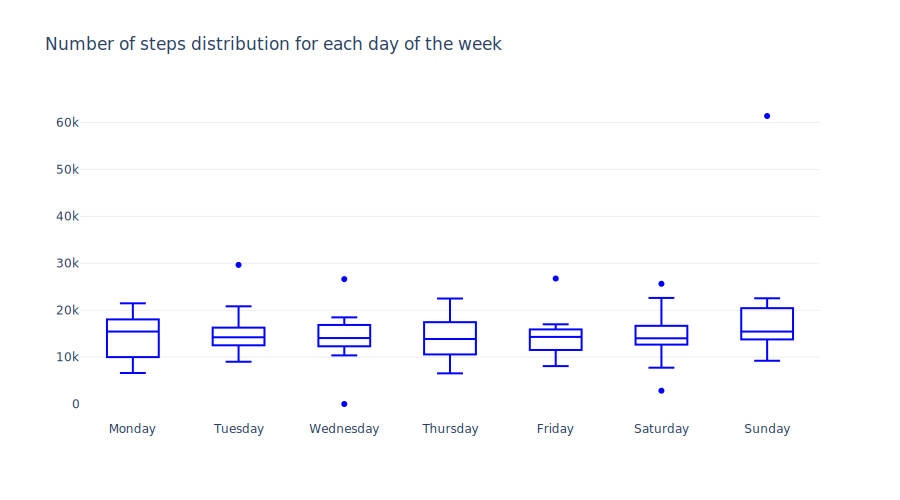

In [45]:
fig = go.Figure()
for i in days:
    y = steps[steps['day'] == i]['steps']
    fig.add_trace(go.Box(y=y, name=i, fillcolor='rgba(0,0,0,0)', line = dict(color='blue')))

fig.update_layout(title_text='Number of steps distribution for each day of the week',
                  width=900, height=500, plot_bgcolor='rgba(0,0,0,0)',
                  yaxis=dict(gridcolor='#EEEEEE', nticks=10), showlegend=False)
pio.show(fig, width=900, height=500)

+ <i>  Outliers for some days of the week are potentially “unusual” days

<b> Median and average number of steps for each day of the week

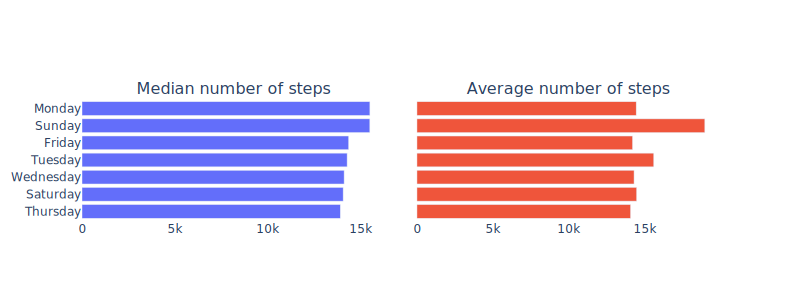

In [46]:
fig = make_subplots(rows=1, cols=2, horizontal_spacing = 0.05, shared_yaxes=True,
                    subplot_titles=('Median number of steps', 'Average number of steps')
                   )
bar_data = steps.groupby(['day'])['steps'].median().sort_values(ascending=True)
fig.add_trace(go.Bar(y=bar_data.index, x=bar_data, width=0.8, orientation='h'), row=1, col=1)

bar_data = steps.groupby(['day'])['steps'].mean()
fig.add_trace(go.Bar(y=bar_data.index, x=bar_data, width=0.8, orientation='h'), row=1, col=2)

fig.update_layout(width=800, height=300, plot_bgcolor='rgba(0,0,0,0)', showlegend=False)
pio.show(fig, width=800, height=300)

+ <i>  The median and average steps for each day of the week are approximately the same. It cannot be said that on the observed interval, the days of the week differ from each other

<b>Weekday and weekend number of steps

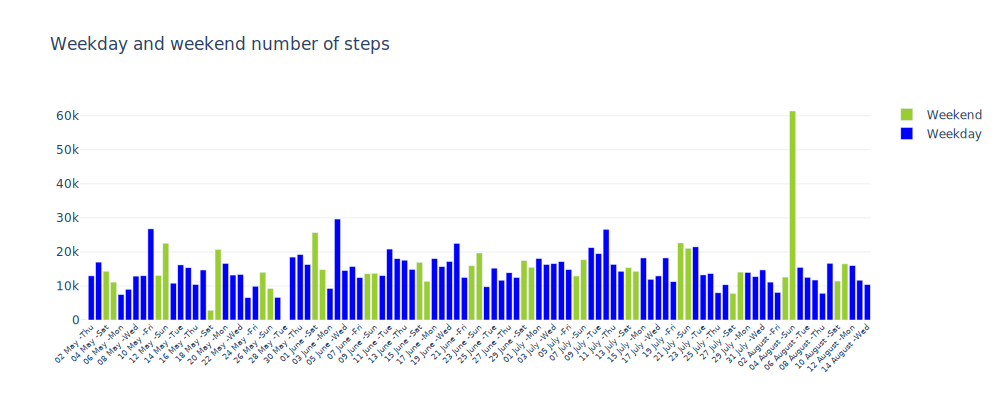

In [47]:
fig = go.Figure()
fig.add_trace(go.Bar(x=steps[steps['day'].isin(['Sunday','Saturday'])]['date'], 
                     y=steps[steps['day'].isin(['Sunday','Saturday'])]['steps'],
                     marker_color='yellowgreen',
                     name='Weekend'))
fig.add_trace(go.Bar(x=steps[~steps['day'].isin(['Sunday','Saturday'])]['date'], 
                     y=steps[~steps['day'].isin(['Sunday','Saturday'])]['steps'],
                     marker_color='blue',
                     name='Weekday')) 
fig.update_layout(title_text='Weekday and weekend number of steps',
                  width=1000,
                  height=400,
                  plot_bgcolor='rgba(0,0,0,0)',
                  xaxis=dict(tickangle=-45, nticks=105, tickformat = '%d %B -%a', tickfont=dict(size=8)),
                  yaxis=dict(gridcolor='#EEEEEE'))
pio.show(fig, width=1000, height=400)

# Days markup function

We determine which day today is “ordinary”, “unusual” or “unknown”, we analyze the history of steps and habits

In [24]:
def define_day(data):
    
    # processing data
    data['date'] = data['Time Start'].str.split(pat='T',expand=True)[0]
    data = pd.DataFrame(data.groupby('date')['Value'].sum()).reset_index()
    data['date'] = pd.to_datetime(data['date'])
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    data['day'] = data['date'].apply(lambda x: x.weekday())
    data = data.rename(columns={'Value': 'steps'})
    for i,j in enumerate(days):
        data['day'] = data['day'].replace({i:j})
    
    # determine the day according to the history of steps for the last 5 days
    temp = data.copy()
    temp['past_std'] = temp['steps'].rolling(5).std().shift()
    temp['past_mean'] = temp['steps'].rolling(5).mean().shift()

    def day_type(row):
        mean = row['past_mean']
        std = row['past_std']
        if row['steps'] >= mean - std or row['steps'] <= mean + std:
             row['day_type'] = 'ordinary day'
        if row['steps'] < mean - std or row['steps'] > mean + std:
             row['day_type'] = 'unusual day'
        if pd.isna(row['past_mean']) == True:
            row['day_type'] = 'unknown day'
        return row['day_type']
    
    temp['day_type'] = ''
    temp['day_type'] = temp.apply(day_type, axis=1)
    
    # finding habits related to the days of the week
    temp['habit'] = ''
    for i in days:
        std = temp[temp['day'] == i]['steps'].rolling(4).std().shift()
        mean = temp[temp['day'] == i]['steps'].rolling(4).mean().shift()
        habit = std/mean
        temp['habit'][habit.index] = habit.values
    
    # check the day of the week taking into account the habits of the last 4 weeks
    for i in range(0, temp.shape[0]):
        day = temp.iloc[i]['day']
        past_days = temp[(temp.index <=i) & (temp['day'] == day)].index[-5:-1].to_list()
        habit = (temp['steps'][i] - temp['steps'][past_days].mean()) / temp['steps'][past_days].mean()
    
        mean = temp['past_mean'][i]
        std = temp['past_std'][i]
        uncommom = temp['steps'][i] < (mean - std) or temp['steps'][i] > (mean + std)
        
        # checking that the habit is maintained (deviation from the previous 4 weeks to 10%) for at least 4 consecutive weeks
        if np.abs(habit) <= 0.1 and temp['habit'][i] <=0.1 and uncommom == True and len(past_days) == 4:
            temp['day_type'][i]='ordinary day'
        elif np.abs(habit) > 0.1 and temp['habit'][i] <=0.1 and len(past_days) == 4:
            temp['day_type'][i]='unusual day'
    data['day_type'] = temp['day_type']
    return data

In [25]:
result = define_day(data)
result.head(10)

,date,steps,day,day_type
0,2019-05-01,21.0,Wednesday,unknown day
1,2019-05-02,12956.0,Thursday,unknown day
2,2019-05-03,17003.0,Friday,unknown day
3,2019-05-04,14312.0,Saturday,unknown day
4,2019-05-05,11124.0,Sunday,unknown day
5,2019-05-06,7467.0,Monday,ordinary day
6,2019-05-07,9027.0,Tuesday,ordinary day
7,2019-05-08,12888.0,Wednesday,ordinary day
8,2019-05-09,12982.0,Thursday,ordinary day
9,2019-05-10,26759.0,Friday,unusual day


In [48]:
def bar_plot(data):
    fig = go.Figure()
    colors = ['lightgrey','blue','red']
    for i,j in enumerate(['unknown day', 'ordinary day', 'unusual day']):
        fig.add_trace(go.Bar(x=data[data['day_type'] == j]['date'], 
                             y=data[data['day_type'] == j]['steps'],
                             marker_color=colors[i],
                             name=j))
    fig.update_layout(title_text='Marked data',
                      width=1000,
                      height=400,
                      plot_bgcolor='rgba(0,0,0,0)',
                      xaxis=dict(tickangle=-45, nticks=105, tickformat = '%d %B -%a', tickfont=dict(size=8)),
                      yaxis=dict(gridcolor='#EEEEEE'))
    pio.show(fig, width=1000, height=400)

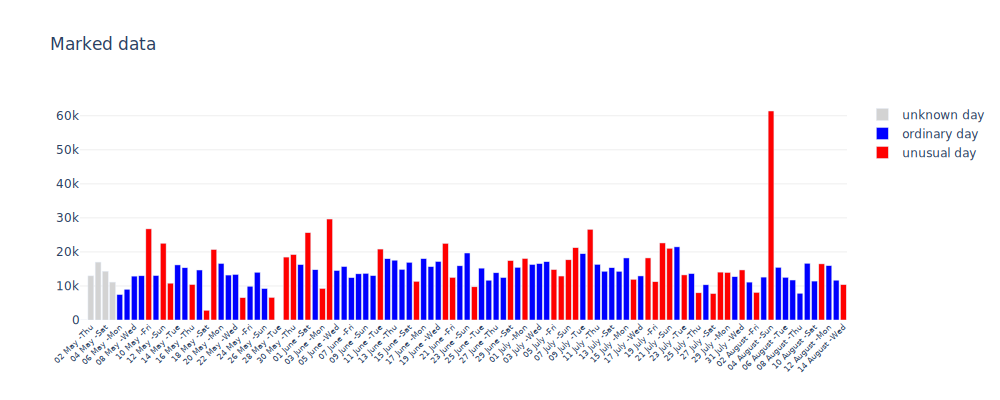

In [49]:
bar_plot(result)

# Validation

<b> Let's check how the function works on the generated data taking into account weekly patterns

In [28]:
# data preprocessing
test = data[['Time Start','Value','date']][0:105]
test['Time Start'] = result['date'].astype(str)
test['Value'] = result['steps']

In [29]:
# generate random data and habits by day of the week
test['Value'] = np.random.randint(5000, 15000, size=test.shape[0])
for i in ['2019-05-27','2019-06-03','2019-06-10','2019-06-17','2019-06-24']:
    test['Value'].iloc[test[test['Time Start'] == i].index] = 20000
test['Value'][test[test['Time Start'] =='2019-07-01'].index] = test[test['Time Start'] =='2019-06-30']['Value']

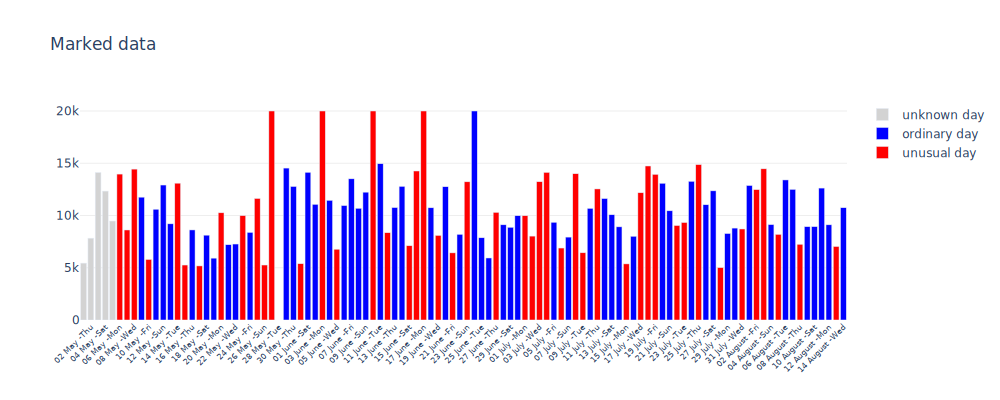

In [50]:
bar_plot(define_day(test))

<i> From May 27 to June 17, the user developed the habit of walking 20 thousand steps every day on Mondays.
The first four weeks, such days were considered unusual. For the fifth week, the habit was fixed, so June 24 is a normal day. A week later, the user did unusualnumber of steps in comparison with the usual number of steps on Monday. Therefore, despite the fact that on June 30 and July 1, a person walked an equal number of steps, June 30 is considered an unusual day, as it is a Monday, during which the last 5 weeks he usually walked 20 thousand steps.

# Final thoughts

+ "Ordinary days" are days when the sum of steps per day falls in the range mean-std / mean + std in the time interval of 5 days before the date. Values ​​beyond this range are labeled as “unusual days.”
<br>
     
+ When the user just started to measure the number of steps days are marked as unknown.
<br>

+ The above function of marking days has one important drawback: the division into “ordinary” and “unusual” is based on getting / not falling into a certain interval - on the border of this interval there can be ordinary and unusual days with a slightly different number of steps that can mislead the user.
<br>

+ The function does not take into account the possible summer / winter seasonality. Additional annual data would help to cope with this problem.
<br>

+ The function does not take into account increasing trends. If the user is engaged in sports, gradually increasing the number of steps, for example, during the month, then a day with a reduced number of steps should be considered unusual, even if the sum of steps per day is within the range of one standard deviation in the last 5 days.
<br>

+ Due to the fact that the emphasis is on the number of steps per day, patterns of movement within the day are not taken into account.
<br>

+ Assumptions made in the calculations (habit, memory) could be made by analyzing additional data about sleep patterns, heart rate, nutrition, etc.